In [103]:
import tqdm
import scgen
import numpy as np
import pandas as pd
import pertpy as pt
import anndata as ad
import scanpy as sc
import scvi
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from utils import scanpy_setup, subsample

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(scvi.__version__)
print(pt.__version__)

1.0.4
0.6.0


In [4]:
metrics = ['euclidean', 'spearman_distance', 'mean_absolute_error']  # representative                                                                                                                                                                       
metrics += ['r2_distance', 'pearson_distance', 'mse', 'cosine_distance']  # fast                                                                                                                                                                            
metrics += ['edistance', 'jeffreys', 'mmd', 'ks_test', 't_test', 'wasserstein'] # slow                                                                                                                                                                      
metrics += ['classifier_proba', 'classifier_cp', 'kendalltau_distance']  # newly added  

In [5]:
adata = pt.dt.kang_2018()
scanpy_setup(adata)  # log-normalized
sc.pp.highly_variable_genes(adata, subset=True)
adata

AnnData object with n_obs × n_vars = 24673 × 1876
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

We'll take the scGen tutorial and tutorial data as an example of evaluating a model using different metrics.

In [7]:
train = adata[~((adata.obs["cell_type"] == "CD4 T cells") &
                    (adata.obs["label"] == "stim"))].copy()
stim_adata = adata[((adata.obs['cell_type'] == 'CD4 T cells') & (adata.obs['label'] == 'stim'))]
ctrl_adata = adata[((adata.obs['cell_type'] == 'CD4 T cells') & (adata.obs['label'] == 'ctrl'))]

In [8]:
scgen.SCGEN.setup_anndata(train, batch_key="label", labels_key="cell_type")

Predict with scGen several times, changing the hyperparamters.

In [151]:
preds = {}

In [152]:
model = scgen.SCGEN(train)
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

pred, delta = model.predict(
    ctrl_key='ctrl',
    stim_key='stim',
    celltype_to_predict='CD4 T cells'
)
pred.obs['label'] = 'pred'

scgen_pred = subsample(ad.concat([stim_adata, pred]), 5000, 'label')
scgen_pred.layers['lognorm'] = scgen_pred.X

preds['scGen_default'] = scgen_pred

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8fc8b6f3-b066-fc74-facd-919b65801960/1/0]
Set SLURM handle signals.


Epoch 37/100:  37%|███▋      | 37/100 [02:26<04:09,  3.96s/it, loss=98.4, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 791.689. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [260]:
model = scgen.SCGEN(train, n_latent=50, n_layers=1, n_hidden=800)
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

pred, delta = model.predict(
    ctrl_key='ctrl',
    stim_key='stim',
    celltype_to_predict='CD4 T cells'
)
pred.obs['label'] = 'pred'

scgen_pred = subsample(ad.concat([stim_adata, pred]), 5000, 'label')
scgen_pred.layers['lognorm'] = scgen_pred.X

preds['scGen_shallow'] = scgen_pred

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8fc8b6f3-b066-fc74-facd-919b65801960/1/0]
Set SLURM handle signals.


Epoch 29/100:  29%|██▉       | 29/100 [01:38<04:00,  3.39s/it, loss=97.2, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 596.733. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


We'll also train a linear regression model on the same task. Of course, we would not expect a linear regression to be able to predict a completely unseen covariate as scGen does, but for the purposes of this performance comparison, it does not matter.

In [154]:
%%time
X = train.X.A
y_train = train.X.A

X_t = ctrl_adata.X.A
y_test = stim_adata.X.A

# use a one-hot for ctrl/stim
ohe = OneHotEncoder()

train_labels = train.obs.label.values
test_labels = np.array(['stim']*ctrl_adata.shape[0])

X_train = np.concatenate([
    X,
    ohe.fit_transform(train_labels.reshape(-1, 1)).A
], axis=1)
X_test = np.concatenate([
    X_t,
    ohe.transform(test_labels.reshape(-1, 1)).A
], axis=1)

# train a linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)

CPU times: user 49 s, sys: 1.12 s, total: 50.1 s
Wall time: 9.92 s


LinearRegression()

In [155]:
reg_pred = pred.copy()
reg_pred.X = reg.predict(X_test)[:reg_pred.shape[0]]  # resize because scGen samples from a distribution
reg_pred = subsample(ad.concat([stim_adata, reg_pred]), 5000, 'label')
reg_pred.layers['lognorm'] = reg_pred.X
preds['linreg'] = reg_pred

Examine how the prediction evaluation would look if we used various different metrics. The standard one has been R2. (TODO: there's a bug here in onesided)

In [261]:
dfs = []
for k, model_pred in preds.items():
    perf_dict = {}
    for metric in tqdm.tqdm(metrics):
        met = pt.tl.Distance(metric=metric, layer_key='lognorm')
        # take distance from real to predicted
        try:
            perf_dict[metric] = met.onesided_distances(model_pred, 'label', selected_group='stim', show_progressbar=False, n_jobs=-1)
        except:
            pass
    dfs.append(pd.DataFrame.from_dict(perf_dict, orient='index').add_suffix(f'_{k}'))
perf_df = pd.concat(dfs, axis=1)
perf_df = perf_df[[c for c in perf_df.columns if 'pred' in c]]

100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


In [273]:
def plot(df, cols=None):
    if cols:
        df = df[cols].copy()
    else:
        df = df.copy()

    df.index = [' '.join(x.split('_')) for x in df.index]
    df = df.rename({
        'euclidean':'Euclidean',
        'mse':'MSE',
        'mmd':'MMD',
        'edistance':'E-distance',
        'pearson distance': 'Pearson',
        't test': 'T-test',
        'r2 distance': 'R2',
        'ks test': 'KS statistic',
        'kendalltau distance': 'Kendall tau distance',
        'spearman distance': 'Spearman',
        'classifier cp': 'classifier class projection',
        'wasserstein':'Wasserstein',
        'jeffreys':'symmetric KL div.'
    })

    df = df.div(df.max(axis=1), axis=0)
    df = 1.01 - df
    
    df.columns = [' '.join(c.split('_')[1:]) for c in df.columns]

    plt.figure(figsize=(3, 8))
    sns.barplot(x='value', y='index', hue='variable', data=pd.melt(df.reset_index(), id_vars='index'))
    plt.legend()
    plt.xlabel(None)
    plt.ylabel(None)
    plt.grid(False)
    plt.show()
#     raise ValueError

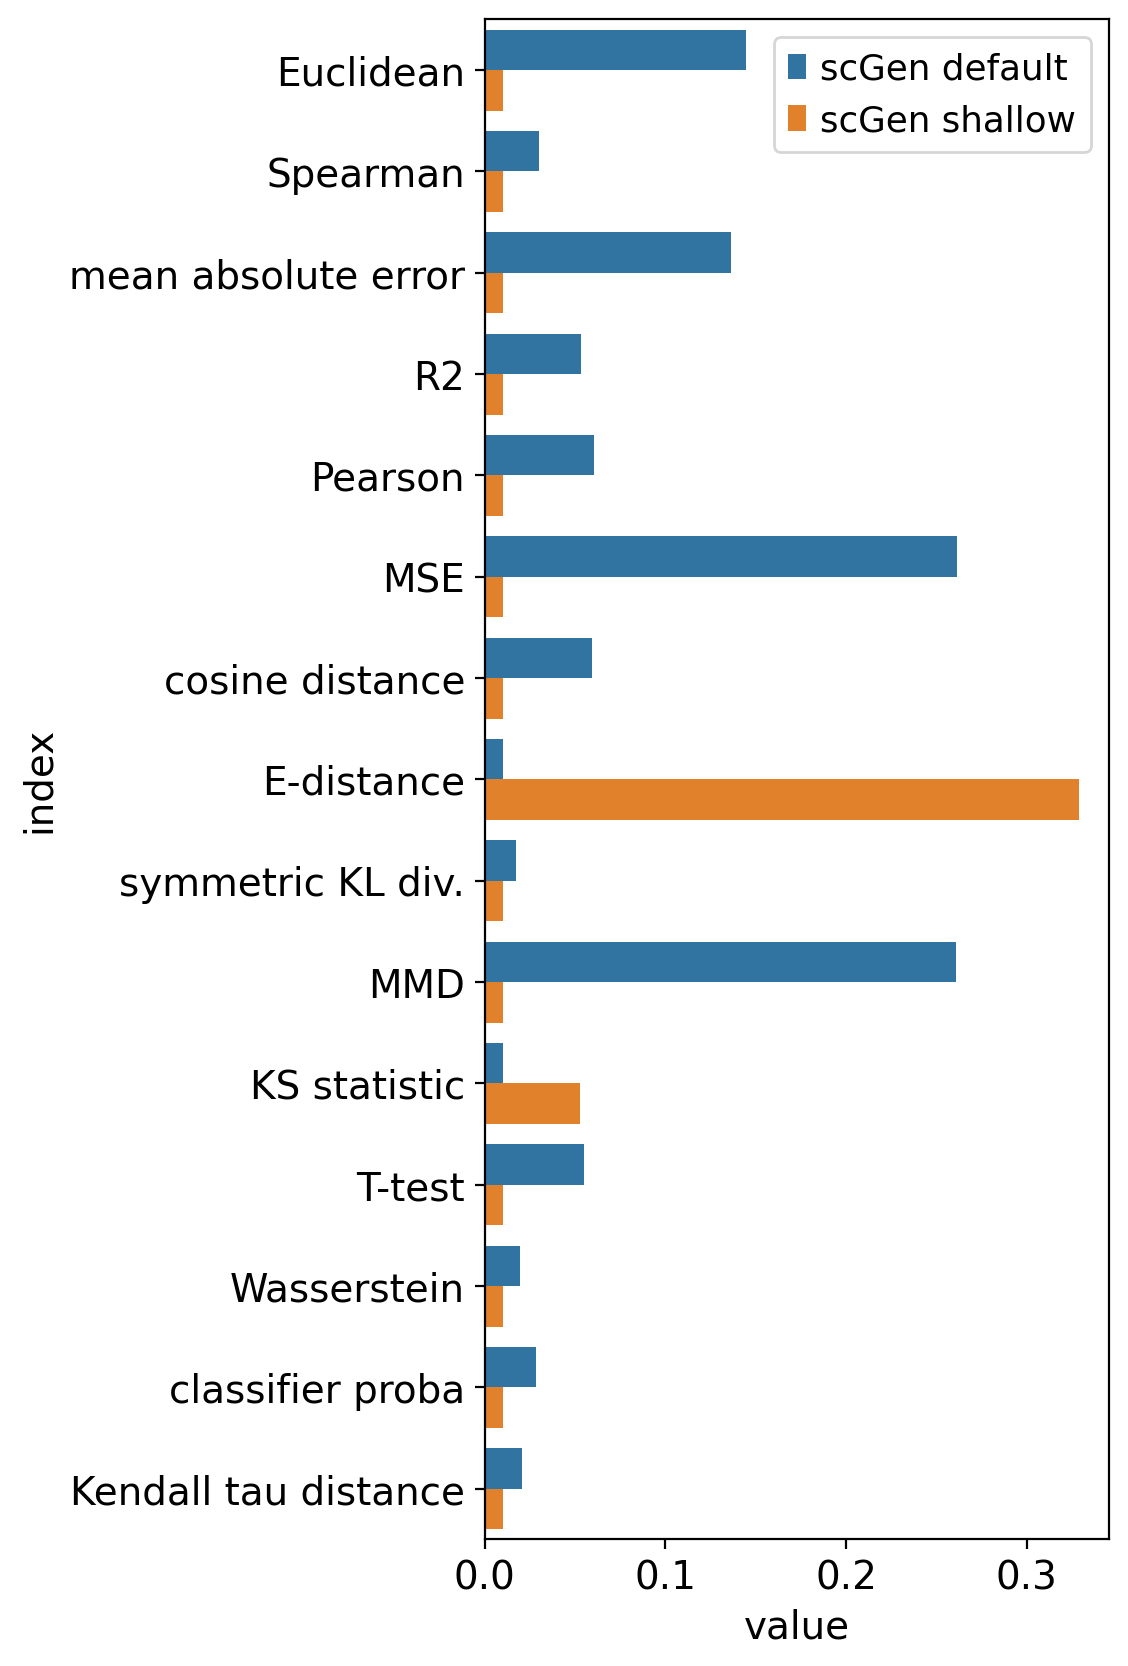

In [263]:
plot(perf_df, ['pred_scGen_default', 'pred_scGen_shallow'])

Also evaluate the prediction using the top 50 DEGs as in the original tutorial.

In [160]:
CD4T = adata[adata.obs.cell_type == 'CD4 T cells']
sc.tl.rank_genes_groups(CD4T, groupby="label", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stim"]

In [264]:
dfs = []
for k, model_pred in preds.items():
    perf_dict = {}
    for metric in tqdm.tqdm(metrics):
        met = pt.tl.Distance(metric=metric, layer_key='lognorm')
        # take distance from real to predicted
        try:
            perf_dict[metric] = met.onesided_distances(model_pred[:, diff_genes[:10]], 'label', selected_group='stim', show_progressbar=False, n_jobs=-1)
        except:
            pass
    dfs.append(pd.DataFrame.from_dict(perf_dict, orient='index').add_suffix(f'_{k}'))
deg_perf_df = pd.concat(dfs, axis=1)
deg_perf_df = deg_perf_df[[c for c in deg_perf_df.columns if 'pred' in c]]

100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


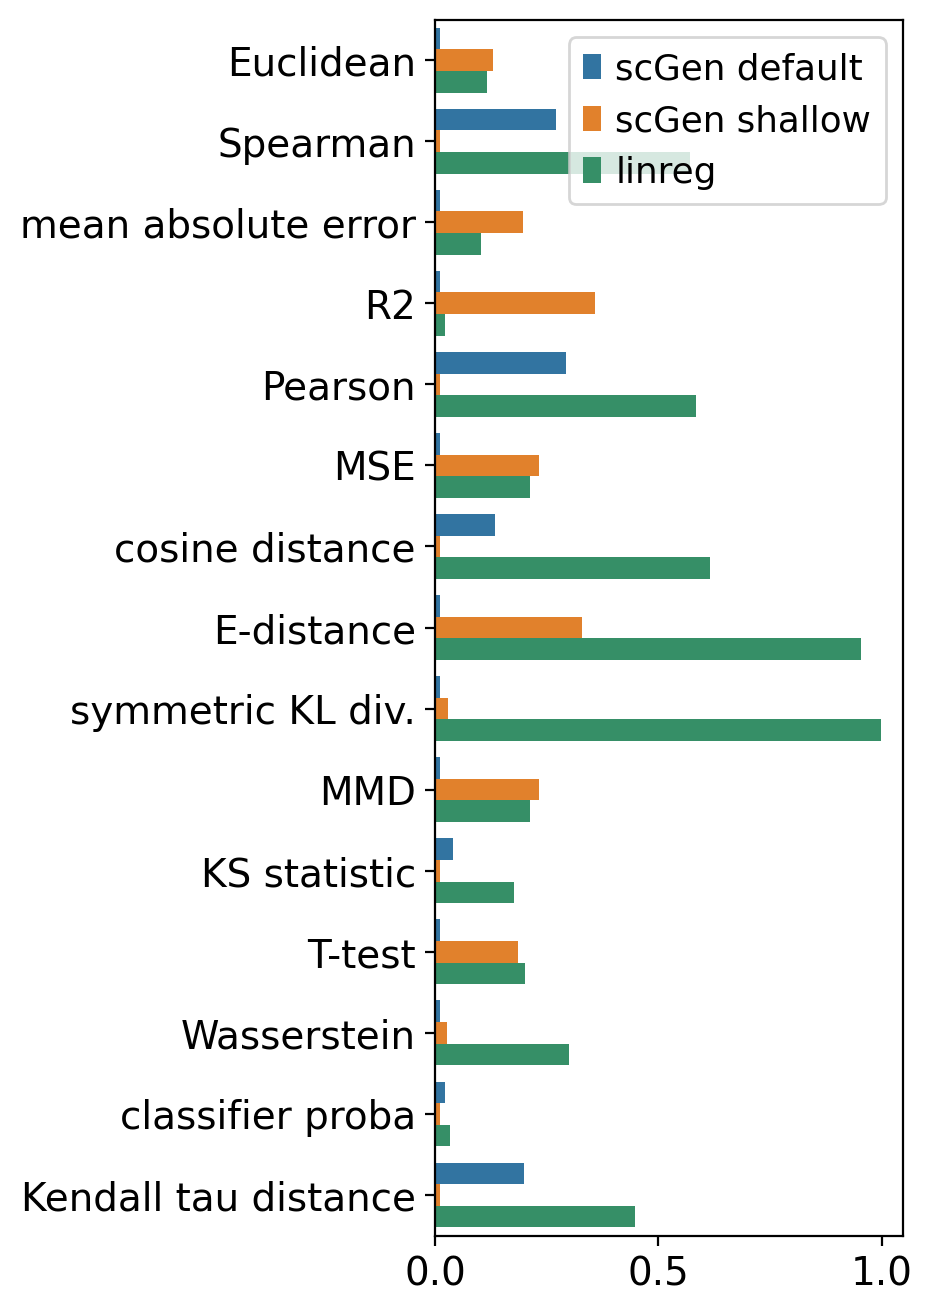

ValueError: 

In [274]:
plot(deg_perf_df)
raise ValueError()